<font color=red size=6>PREDICTIONS</font>

**Pere Mayol Carbonell, NIU:1669503** <br>

In [6]:
#import everything we need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')#just to make the plots look better.

#regarding the training and validation of thje data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [7]:
#Read the data and print the first 10 elements to check its okay.
data_EE = pd.read_csv('/content/Consum-energia-Q-2018-2023-horari(1).csv')
data_EE.head(200)

,Date,Hour,Q-Enginyeria-Total [kWh]
0,1/1/2018,00:00,177.00
1,1/1/2018,01:00,177.44
2,1/1/2018,02:00,176.57
3,1/1/2018,03:00,174.98
4,1/1/2018,04:00,174.51
...,...,...,...
195,1/9/2018,03:00,192.05
196,1/9/2018,04:00,196.69
197,1/9/2018,05:00,219.47
198,1/9/2018,06:00,332.88


In [13]:
#identifica valors problematics per a treballar amb datetime per a poder eliminarlos.
problematic_entries = data_EE[pd.to_datetime(data_EE['Date'], errors='coerce').isna()]
problematic_entries.head()

,Date,Hour,Q-Enginyeria-Total [kWh]
53629,"19:00""",259.87,NaN
71023,"19:00""",259.87,NaN


In [14]:
#treiem les entrdes problemàtiques.
data_cleaned = data_EE.drop(problematic_entries.index)
#ara que no tenim entrades problemàtiques, canvia el format de 'Date' a datetime.
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'], format='%m/%d/%Y')
data_cleaned['YearMonth'] = data_cleaned['Date'].dt.to_period('M') #treiem mes i any de la columna.

#agrupem per any i mes.
monthly_data = data_cleaned.groupby('YearMonth')['Q-Enginyeria-Total [kWh]'].sum().reset_index()

#tornem a passarho a datetime.
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()

#per a veure les primeres rows.
print(monthly_data.head())

   YearMonth  Q-Enginyeria-Total [kWh]
0 2018-01-01                 203097.88
1 2018-02-01                 201824.73
2 2018-03-01                 198795.75
3 2018-04-01                 191264.50
4 2018-05-01                 180644.13


In [23]:
#Extreure les dades mitges de cada mes.
monthly_mean_data = data_cleaned.groupby('YearMonth')['Q-Enginyeria-Total [kWh]'].mean().reset_index()

#Per a veure que funcioni correctament.
monthly_mean_data.head(200)

,YearMonth,Q-Enginyeria-Total [kWh]
0,2018-01,272.981022
1,2018-02,300.334420
2,2018-03,267.558210
3,2018-04,265.645139
4,2018-05,242.801250
...,...,...
69,2023-10,265.646577
70,2023-11,234.724542
71,2023-12,199.055148
72,2024-01,204.538306


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


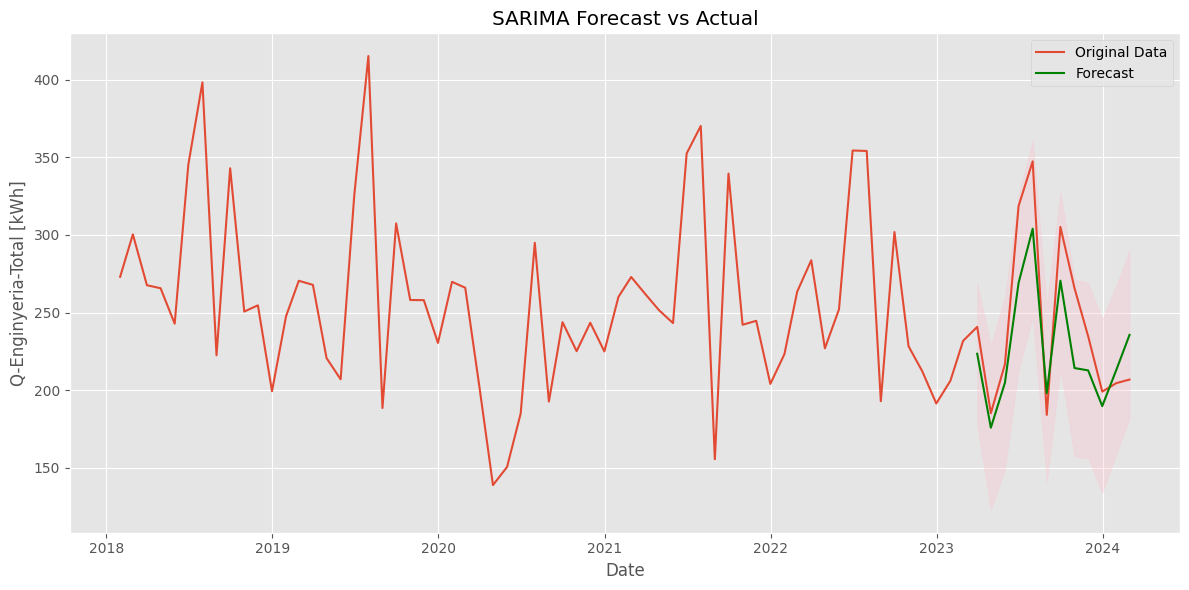

In [57]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#load the fie.
file_path = '/content/Consum-energia-Q-2018-2023-horari(1).csv'
data = pd.read_csv(file_path)

#convert dat to datatime format.
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])  #drop rows where date conversion was not possible.

#aggregate data monthly and create 'mec' DataFrame
mec = data.groupby(pd.Grouper(key='Date', freq='M'))['Q-Enginyeria-Total [kWh]'].mean().reset_index()
mec = mec.set_index('Date')

from statsmodels.tsa.statespace.sarimax import SARIMAX

#define the parameters needed for SARIMA.
p, d, q = 1, 1, 1
P, D, Q, s = 2, 1, 1, 12

#make data split
train_data = mec.iloc[:-12]
test_data = mec.iloc[-12:]   #everything unless the last 12 months is for training, then we can see the predictions.

#fit the SARIMA model with the parameters created before.
model = SARIMAX(train_data['Q-Enginyeria-Total [kWh]'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

#make predictions
forecast = results.get_forecast(steps=len(test_data))
forecast = forecast.conf_int()
forecast['forecast'] = results.predict(start=forecast.index[0], end=forecast.index[-1])

#plot originla vs predicted.
plt.figure(figsize=(12, 6))
plt.plot(mec.index, mec['Q-Enginyeria-Total [kWh]'], label='Original Data')
plt.plot(forecast.index, forecast['forecast'], label='Forecast', color='green')
plt.fill_between(forecast.index,
                 forecast.iloc[:, 0],
                 forecast.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Q-Enginyeria-Total [kWh]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
